In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as utils

In [2]:
class BruteOSFMetric(metrics.BaseMetric):
    """Assume I can't trust the slewtime or visittime colums"""
    def __init__(self, metricName='BruteOSFMetric',
            expTimeCol='expTime', mjdCol='expMJD', maxgap=10., fudge=0, **kwargs):
        self.expTimeCol = expTimeCol
        self.maxgap = maxgap/60./24. # convert from min to days
        self.mjdCol = mjdCol
        self.fudge = fudge
        super(BruteOSFMetric, self).__init__(col=[self.expTimeCol, mjdCol],
                                                        metricName=metricName, units='OpenShutter/TotalTime',
                                                        **kwargs)
                                                                                                        
    def run(self, dataSlice, slicePoint=None):
        times = np.sort(dataSlice[self.mjdCol])
        diff = np.diff(times)
        good = np.where(diff < self.maxgap)
        openTime = np.sum(diff[good])*24.*3600.
        result = np.sum(dataSlice[self.expTimeCol]+self.fudge) / float(openTime)
        return result


In [3]:
conns = []
colmap_dicts = []
conns.append(db.OpsimDatabase('opsim3_61_sqlite.db', defaultTable='Summary'))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'expTime', 'visittime': 'expTime', 'mjd':'expMJD'})



conns.append(db.OpsimDatabase('opsimblitz2_1060_sqlite.db', defaultTable='Summary'))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})


conns.append(db.OpsimDatabase('enigma_1189_sqlite.db', defaultTable='Summary'))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})


conns.append(db.OpsimDatabase('minion_1016_sqlite.db', defaultTable='Summary'))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})



In [4]:
results = []
i=0
for conn,colmap_dict in zip(conns, colmap_dicts):
    bundleList = []
    sql = ''
    slicer = slicers.UniSlicer()
    if i == 0:
        fudge = -4.
    else:
        fudge = 0.
    i += 1
    metric = BruteOSFMetric(expTimeCol=colmap_dict['exptime'],
                                   mjdCol=colmap_dict['mjd'], fudge=fudge)
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    metric = metrics.MedianMetric(col='normairmass')
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    metric = metrics.MedianMetric(col=colmap_dict['slewtime'])
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    group = metricBundles.MetricBundleGroup(bd, conn)
    group.runAll()
    results.append(bundleList)

Querying database Summary with no constraint for columns ['expTime', 'slewTime', 'airmass', 'expMJD', 'fieldDec'].
Found 2651588 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_normairmass_UNIS', 'opsim_Median_slewTime_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with no constraint for columns ['slewTime', 'visitExpTime', 'airmass', 'expMJD', 'fieldDec'].
Found 2551637 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_normairmass_UNIS', 'opsim_Median_slewTime_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with no constraint for columns ['slewTime', 'visitExpTime', 'airmass', 'expMJD', 'fieldDec'].
Found 2469307 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_normairmass_UNIS', 'opsim_Median_slewTime_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Complete

In [5]:
osf = [bl[0].metricValues for bl in results]
normAir = [bl[1].metricValues for bl in results]

In [6]:
normAir

[masked_array(data = [1.0958415071696619],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.1234914484593699],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.0775495831422173],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.073198000531009],
              mask = [False],
        fill_value = -666.0)]

In [7]:
osf

[masked_array(data = [0.7431762502397868],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7555777866507578],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7333276606428204],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.735662801166647],
              mask = [False],
        fill_value = -666.0)]

In [8]:
conns = []
colmap_dicts = []
conns.append(db.Database('marching_d30.db', defaultTable='SummaryAllProps'))
colmap_dicts.append({'slewtime': 'slewtime', 'exptime': 'exptime', 'visittime': 'exptime', 'mjd':'mjd'})



In [9]:
results = []
i=0
for conn,colmap_dict in zip(conns, colmap_dicts):
    bundleList = []
    sql = ''
    slicer = slicers.UniSlicer()
    metric = BruteOSFMetric(expTimeCol=colmap_dict['exptime'],
                                   mjdCol=colmap_dict['mjd'])
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    stacker = stackers.NormAirmassStacker(decCol='dec')
    metric = metrics.MedianMetric(col='normairmass')
    bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
    bundleList.append(bundle)
    
    metric = metrics.MedianMetric(col=colmap_dict['slewtime'])
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    group = metricBundles.MetricBundleGroup(bd, conn)
    group.runAll()
    results.append(bundleList)

Querying database SummaryAllProps with no constraint for columns ['exptime', 'mjd', 'dec', 'slewtime', 'airmass'].
Found 21287 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_normairmass_UNIS', 'opsim_Median_slewtime_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [10]:
feature_osf = bundleList[0].metricValues
feature_nair = bundleList[1].metricValues

In [11]:
print(feature_osf, feature_nair)

[0.7792537530840773] [1.0135975250524485]


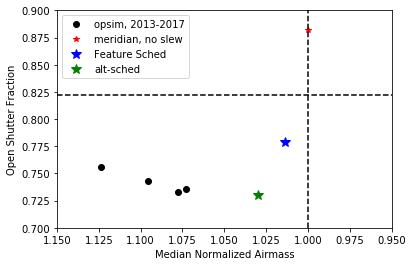

In [12]:
max_osf = 30./(34)
plt.plot(normAir, osf, 'ko', label='opsim, 2013-2017')
plt.xlim([1.15, .95])
plt.ylim([.7, .9])
plt.plot(1, max_osf, 'r*', label='meridian, no slew')
plt.xlabel('Median Normalized Airmass')
plt.ylabel('Open Shutter Fraction')
plt.axhline(y=30./(32.+4.5), linestyle='--', color='k')
plt.axvline(x=1., linestyle='--', color='k')

plt.plot(feature_nair, feature_osf, 'b*', markersize=10, label='Feature Sched')

plt.plot([1.03], [0.73], 'g*', markersize=10, label='alt-sched')

plt.legend(scatterpoints=1, numpoints=1, loc='upper left')

In [24]:
osf


[masked_array(data = [1.064878345703516],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7566426159038202],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7344555797128759],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7357682852032515],
              mask = [False],
        fill_value = -666.0)]

In [14]:
feature_nair


masked_array(data = [1.0135975250524485],
             mask = [False],
       fill_value = -666.0)

In [15]:
conn = db.SimpleDatabase('marching_d30.db', defaultTable='SummaryAllProps',
                               defaultdbTables={'SummaryAllProps': ['SummaryAllProps', 'observationId']})

Querying database SummaryAllProps with no constraint for columns ['airmass', 'dec'].
Found 21287 visits
Running:  ['opsim_Count_normairmass_ONED']
Completed metric generation.
Running:  ['opsim_Median_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 201 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:115: UserWarning: Warning - column normairmass already present in simData, will be overwritten.
  % (col))


Plotting complete.


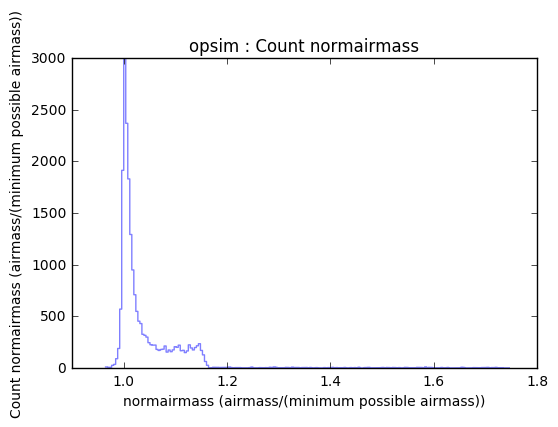

In [16]:
bundleList = []
sql = ''
slicer = slicers.OneDSlicer(sliceColName='normairmass')
stacker = stackers.NormAirmassStacker(decCol='dec')
metric = metrics.CountMetric(col='normairmass')
bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
bundleList.append(bundle)

metric = metrics.MedianMetric(col='normairmass')
slicer=slicers.UniSlicer()
bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
bundleList.append(bundle)


bd = metricBundles.makeBundlesDictFromList(bundleList)
group = metricBundles.MetricBundleGroup(bd, conn)
group.runAll()
group.plotAll(closefigs=False)

In [17]:
print bundleList[1].metricValues

[1.0135975250524485]
